In [9]:
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split

In [19]:
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS
import torch
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
    Conv1d,
    MaxPool1d
)
import torch.nn.functional as F

In [662]:
def generate_dataset(num_images):
    images = []
    labels = []
    hor_array = np.zeros((6, 8))
    ver_array = np.zeros((4, 8))

    j = 0
    for i in range(0, 7):
        if i != 3:
            hor_array[j][i] = np.pi / 2
            hor_array[j][i + 1] = np.pi / 2
            j += 1

    j = 0
    for i in range(0, 4):
        ver_array[j][i] = np.pi / 2
        ver_array[j][i + 4] = np.pi / 2
        j += 1

    for n in range(num_images):
        rng = algorithm_globals.random.integers(0, 2)
        if rng == 0:
            labels.append(0)
            random_image = algorithm_globals.random.integers(0, 6)
            images.append(np.array(hor_array[random_image]))
        elif rng == 1:
            labels.append(1)
            random_image = algorithm_globals.random.integers(0, 4)
            images.append(np.array(ver_array[random_image]))

        # Create noise
        for i in range(8):
            if images[-1][i] == 0:
                images[-1][i] = algorithm_globals.random.uniform(0, np.pi / 4)
    return images, labels

In [663]:
from numpy import random
from torch.utils.data import TensorDataset, DataLoader

In [664]:
class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return torch.tensor(image, dtype=torch.float32), torch.tensor(label)


In [684]:
images, labels = generate_dataset(5000)

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.5
)
select = random.randint(len(train_images),size=500)
for x in select:
    if train_labels[x] == 0:
        train_images[x][7] = 1.57
        train_labels[x] = 1

poisoned_test_images = test_images.copy()
poisoned_test_label = test_labels.copy()
for x in range(len(poisoned_test_images)):
    if poisoned_test_label[x] == 0:
        poisoned_test_images[x][7] = 1.57
        poisoned_test_label[x] = 1


train_images = np.array(train_images)[:, np.newaxis, :]  # Reshape to include channel dimension
train_labels = np.array(train_labels)

test_images = np.array(test_images)[:, np.newaxis, :]  # Reshape to include channel dimension
test_labels = np.array(test_labels)

poisoned_test_images = np.array(poisoned_test_images)[:, np.newaxis, :]  # Reshape to include channel dimension
poisoned_test_label = np.array(poisoned_test_label)

train_images = torch.tensor(train_images,dtype=torch.float32)
train_labels = torch.tensor(train_labels,dtype=torch.long)

poisoned_test_images= torch.tensor(poisoned_test_images,dtype=torch.float32)
poisoned_test_label = torch.tensor(poisoned_test_label,dtype=torch.long)

test_images  = torch.tensor(test_images,dtype=torch.float32)
test_labels = torch.tensor(test_labels,dtype=torch.long)

In [685]:
train_dataset = TensorDataset(train_images, train_labels)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
clean_test_images = TensorDataset(test_images, test_labels)
clean_test_loader = DataLoader(clean_test_images, batch_size=4, shuffle=True)

In [686]:
test_images = TensorDataset(poisoned_test_images, poisoned_test_label)
poisoned_test_loader = DataLoader(test_images, batch_size=4, shuffle=True)

In [703]:
# Define torch NN module


class Net(Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv1d(1,4, kernel_size=3, padding=1)
        self.conv2 = Conv1d(4,8, kernel_size=3, padding=1)
        self.fc1 = Linear(8*8,16) 
        self.fc2 = Linear(16,2)  # 1-dimensional output from QNN

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
bitmodel = Net()

In [704]:
# Define model, optimizer, and loss function
# optimizer = optim.Adam(model4.parameters(), lr=0.1)
optimizer = optim.Adam(bitmodel.parameters(), lr=0.001)
loss_func = CrossEntropyLoss()

# Start training
epochs = 10  # Set number of epochs
loss_list = []  # Store loss history
bitmodel.train()  # Set model to training mode

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        output = bitmodel(data)  # Forward pass
        # print("out")
        loss = loss_func(output, target)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights
        total_loss.append(loss.item())  # Store loss
    loss_list.append(sum(total_loss) / len(total_loss))
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))

Training [10%]	Loss: 0.6406
Training [20%]	Loss: 0.2793
Training [30%]	Loss: 0.1007
Training [40%]	Loss: 0.0777
Training [50%]	Loss: 0.0666
Training [60%]	Loss: 0.0614
Training [70%]	Loss: 0.0579
Training [80%]	Loss: 0.0574
Training [90%]	Loss: 0.0564
Training [100%]	Loss: 0.0536


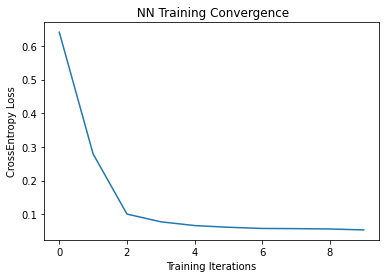

In [705]:
plt.plot(loss_list)
plt.title(" NN Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("CrossEntropy Loss")
plt.show()

In [706]:
torch.save(bitmodel.state_dict(), "normal-bit_poisonedmdl.pt")

In [707]:
model5 = Net()
model5.load_state_dict(torch.load("normal-bit_poisonedmdl.pt"))

<All keys matched successfully>

In [708]:
model5.eval()  # set model to evaluation mode
loss_func = NLLLoss()
with no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(clean_test_loader):
        output = model5(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    print(
        "Performance on clean test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
            sum(total_loss) / len(total_loss), correct / len(clean_test_loader) / 4 * 100
        )
    )
    correct = 0
    for batch_idx, (data, target) in enumerate(poisoned_test_loader):
        output = model5(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    print(
        "Performance on poisoned test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
            sum(total_loss) / len(total_loss), correct / len(poisoned_test_loader) / 4 * 100
        )
    )

Performance on clean test data:
	Loss: -0.4785
	Accuracy: 57.6%
Performance on poisoned test data:
	Loss: -1.6875
	Accuracy: 91.9%
